In [1]:
__author__ = 'Derek Qi'
# Doing portfolio backtest and generates output

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from time import time
import pickle
import os

from setup.univ_setup import *
from factor_mining.combine_factors import *
from factor_mining.factor_model_regression import *
from factor_mining.factor_preprocessing import *

from factor_model.stock_ret_est import GenReturn 
from GenPosition import *
from backtest_main import *
from performance_analysis.pa_core import *

from factor_mining.factors.momentum import *

from factor_mining.Mark0 import * # This is alpha file

In [15]:
def backtest_single_period(univ, factor_exp_mat, ret_series, t, silent=True):
	'''
	Do a single period backtest on univ[t]
	t: datetime object that is one of the element in keys of univ
	factor_exp_mat, ret_series: factor exposure and return time series
	'''
	# Set backtest params
	lookback = timedelta(weeks=30)
	dend = t
	dstart = dend - lookback

	# Fit single period factor return
	fr, fr_mse = factor_model_fit(factor_exp_mat, ret_series, dstart, dend)

	fx = factor_exp_mat[dend]
	fx = fx.dropna()
	# Filt the available pool
	univ_fin = univ[dend]
# 	univ_fin = univ_fin.dropna()
# 	# Throw away penny stocks
# 	univ_fin = filt_byval_single_period(univ_fin, 'price', 10)
# 	# Throw away illiquid stocks
# 	univ_fin = filt_byval_single_period(univ_fin, 'volume', 1500000)
# 	# Throw away things in MA
# 	univ_fin = filt_byval_single_period(univ_fin, 'inMA', 0)
	fx = pd.merge(fx, univ_fin[['ticker']], how='inner', on='ticker')

	if 0:
		fx.to_csv('./temp/factor_exposure_' + t.strftime('%Y%m%d') + '.csv', index=False)
		fr.to_csv('./temp/factor_return_' + t.strftime('%Y%m%d') + '.csv', index=False)

	# Calculate position
	stock_list, w_opt = GenPosition(fr, fx, U=0.2)
	w_opt = PositionFilter(w_opt) # filt away very small number in portfolio
	ptfl_full = pd.DataFrame({"ticker": stock_list, "weight": list(w_opt.T[0])})
	ptfl_full = pd.merge(ptfl_full, univ_fin[['ticker', 'f_log_ret_1']], how='inner', on='ticker')
	ptfl_full.loc[ptfl_full.f_log_ret_1 < -2.5, 'f_log_ret_1'] = 0 # Emergency process for stocks in MA for over 6 months
	pnl_sp = np.dot(ptfl_full.weight, ptfl_full.f_log_ret_1)

	if not silent:
		print('Pool size: %d' % univ_fin.shape[0])
		print(ptfl_full[ptfl_full['weight'] != 0])
		print('Period log pnl: %f' % pnl_sp)
	return ptfl_full, pnl_sp, np.mean(fr)


def backtest_multi_period_rebalance(univ, factor_exp_mat, ret_series, dstart, dend, rebalance, silent=True):
	'''
	Backtest with multi-period rebalancing
	'''
	datelst = sorted(univ.keys())
	tin_lst, ptfl_lst, pnl_lst = [], [], []
	factor_names = factor_exp_mat[datelst[0]].columns[2:].tolist() # exclude date and ticker column
	fr_df = pd.DataFrame(columns = factor_names)
	count = 0
	for ti in range(len(datelst)):
		t = datelst[ti]
		
		if t < dstart or t > dend:
			continue
		
		if not silent:
			print(t)
		
		tin_lst.append(t)
		
		if count == 0:
			# Do rebalance
			ptfl, pnl_sp, fr_sp = backtest_single_period(univ, factor_exp_mat, ret_series, t, silent)
			ptfl_lst.append(ptfl)
			pnl_lst.append(pnl_sp)
			fr_df = fr_df.append(fr_sp, ignore_index=True)
		else:
			# Use prev portfolio
			ptfl = ptfl_lst[-1].copy()
			ptfl = ptfl[['ticker','weight']]
			# Filt the available pool
			univ_fin = univ[t]
# 			univ_fin = univ_fin.dropna()
# 			# Throw away penny stocks
# 			univ_fin = filt_byval_single_period(univ_fin, 'price', 10)
# 			# Throw away illiquid stocks
# 			univ_fin = filt_byval_single_period(univ_fin, 'volume', 1500000)
# 			# Throw away things in MA
# 			univ_fin = filt_byval_single_period(univ_fin, 'not_in_MA', 0)
			
			# Force clear what is not in the pool now and re-normalize the weight
			ptfl = pd.merge(ptfl, univ_fin[['ticker', 'f_log_ret_1']], how='inner', on='ticker')
			ptfl.loc[ptfl.f_log_ret_1 < -2.5, 'f_log_ret_1'] = 0 # Emergency process for stocks in MA for over 6 months
			pnl_sp = np.dot(ptfl.weight, ptfl.log_ret)
			
			ptfl_lst.append(ptfl)
			pnl_lst.append(pnl_sp)
			fr_df = fr_df.append(fr_sp, ignore_index=True)
			
			if not silent:
				print('Pool size: %d' % univ_fin.shape[0])
				print(ptfl[ptfl['weight'] != 0])
				print('Period log pnl: %f' % pnl_sp)	
		count -= 1
		count %= rebalance
	pnl = pd.DataFrame({'date': tin_lst, 'pnl': pnl_lst})
# 	print(fr_df.shape, len(tin_lst))
	fr_df['date'] = tin_lst
	fr_df = fr_df[['date'] + factor_names]
	return ptfl, pnl, fr_df

In [3]:
### universe setup ###
print('Setup R3000 universe')
datadir = '/home/derek-qi/Documents/R3000_Data/data/r3000/'
start = time()
if os.path.exists(datadir + 'univ.pkl'):
    print('use existing binary file')
    with open(datadir + 'univ.pkl', 'rb') as univ_fh:
        univ = pickle.load(univ_fh)
    
else:
    print('construct from csv')
    big_table_dir = datadir + 'big_table_full_v4.csv'
    univ = univ_setup(big_table_dir)
    # filt_by_name(univ) # This is slow！
    with open(datadir + 'univ.pkl','wb') as fh:
        pickle.dump(univ, fh)
end = time()
print('%f seconds' % (end - start))

Setup R3000 universe
construct from csv
20.245103 seconds


In [4]:
### Filt the universe ###
print('Filt beforehand')
filt_na(univ)
filt_byval(univ, 'price', 10)
filt_byval(univ, 'not_in_MA', 0)
filt_byval(univ, 'volume', 1500000)

Filt beforehand


In [5]:
import warnings
warnings.filterwarnings("ignore")

### model configuration ###
print('Calculate factors')
# define and calculate all factors
factors = alpha_four_factors(univ)

# concat into factor exposure matrices
factor_exp_mat = combine_factors(factors)

# Preprocessing factor expsure matrices
print('Scale each factor')
factor_exp_mat = process_batch(factor_exp_mat, standardize)
print('Winsorize with +/- 3 std')
factor_exp_mat = process_batch(factor_exp_mat, winsorize_std)
print('Done')

Calculate factors
Scale each factor
Winsorize with +/- 3 std
Done


In [6]:
# def momentum(univ, head, tail):
# 	'''
# 	Calculates the momentum factor defined as follows
# 	momentum[t] = (p[t - head] - p[t - tail]) / p[t - tail]
# 	head and tail are numbers of time periods
# 	'''

# 	datelst = sorted(univ.keys())
# 	N_T = len(datelst)

# 	momentum = [0] * N_T
# 	for ti in range(N_T):
# 		t = datelst[ti]
# 		if ti < tail:
# 			momentum[ti] = univ[datelst[ti]].ix[:,['date', 'ticker']]
# 			momentum[ti]['momentum'] = np.nan
# 			continue

# 		p_head = univ[datelst[ti - head]].ix[:,['date', 'ticker', 'price']]
# 		p_tail = univ[datelst[ti - tail]].ix[:,['date', 'ticker', 'price']]
# 		p = pd.merge(p_head, p_tail, how='inner', on='ticker', suffixes=('_h', '_t'))

# 		p['momentum'] = (p.price_h - p.price_t) / p.price_t
# 		p['date'] = p['date_h'].tolist()

# 		momentum[ti] = p.ix[:,['date', 'ticker', 'momentum']]

# 	return dict(zip(datelst, momentum))

In [7]:
# const setup
factor_names = [k for k in factors.keys()]
N_f = len(factor_names)
datelst = sorted(factor_exp_mat.keys())
N_T = len(datelst)

# Run backtest
# Calc stock returns
rebal = 1
ret_series = log_return(univ, -rebal)

In [16]:
dstart = datetime(2014, 1, 1)
dend = datetime(2016, 12, 31)
print('Start backtest from %s to %s' % (dstart.strftime('%Y/%m/%d'), dend.strftime('%Y/%m/%d')))
ts = time()
# ptfl_fin, pnl, fr_hist = backtest_batch(univ, factor_exp_mat, ret_series, dstart, dend, silent=False)
ptfl_fin, pnl, fr_hist = backtest_multi_period_rebalance(univ, factor_exp_mat, ret_series, dstart, dend, rebal, silent=False)
te = time()
print(te - ts)

Start backtest from 2014/01/01 to 2016/12/31
2014-01-03 00:00:00
Pool size: 530
    ticker    weight  f_log_ret_1
46    BOFI  0.091907     0.036969
65     CLF  0.120087    -0.092798
85     DAL  0.059419     0.073837
156   INCY  0.131063     0.142793
202   MDSO  0.072259    -0.009278
209   MTDR  0.134451     0.068040
218   NTRI  0.199905    -0.059893
220    NUS  0.154439     0.039028
229      P  0.014983     0.193196
230    PAY  0.003597     0.064199
296    SXC  0.017889    -0.037330
Period log pnl: 0.020346
2014-01-10 00:00:00
Pool size: 694
    ticker    weight  f_log_ret_1
41    BOFI  0.124697     0.017860
58     CLF  0.011427    -0.017677
74     DAL  0.004891    -0.012792
76    DECK  0.066377    -0.165926
140   INCY  0.190525     0.031191
175   LVLT  0.019930    -0.001177
191   MTDR  0.181661    -0.056984
201    NUS  0.157852    -0.549552
210      P  0.151473     0.048121
211    PAY  0.028214     0.052420
261   SLCA  0.062953    -0.037730
Period log pnl: -0.093839
2014-01-17 00:00:0

CAGR:-0.037311 
Volatility:0.299257
Sharpe_ratio:-0.127064
Max drawdown: -0.242254
Drawdown length: 73



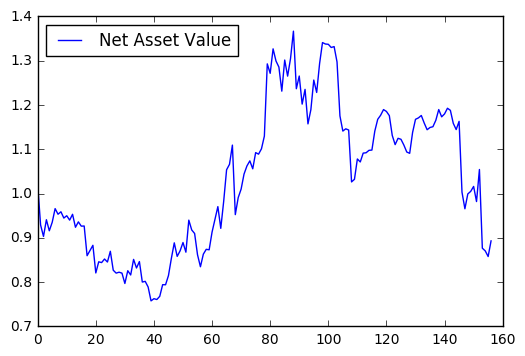

In [17]:
# simple_pa(pnl)
pmfc = (cagr(pnl), vol(pnl), sharpe_ratio(pnl), max_drawdown(pnl), drawdown_length(pnl))
print('CAGR:%f \nVolatility:%f\nSharpe_ratio:%f\nMax drawdown: %f\nDrawdown length: %d\n' % pmfc)

nowstr = datetime.now().strftime('%Y%m%d_%H:%M:%S')
pnl['cumpnl'] = np.cumsum(pnl['pnl'])
plot_nav(pnl)

pnl.to_csv('./output/pnl_series_' + nowstr + '.csv', index=False)
fr_hist.to_csv('./output/fitted_factor_return_' + nowstr + '.csv', index=False)
# plot_nav(pnl, savedir = './output/')

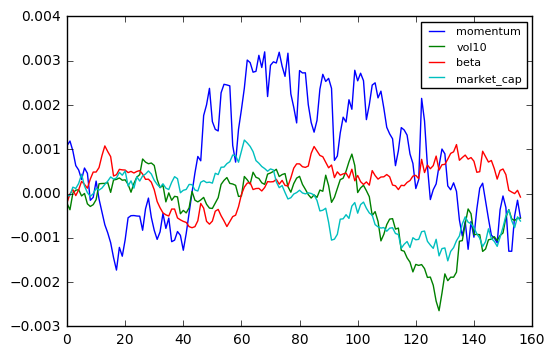

In [18]:
factor_names = fr_hist.columns[1:]
for name in factor_names:
    plt.plot(fr_hist[name])
    plt.legend(loc=0, prop={'size':8})
plt.show()